<a href="https://colab.research.google.com/github/mprksa/kubus5/blob/main/DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
import imgaug.augmenters as iaa

In [2]:
# Clone the repository
!git clone https://github.com/mprksa/Blocks2.git

Cloning into 'Blocks2'...
remote: Enumerating objects: 887, done.
remote: Counting objects: 100% (887/887), done.
remote: Compressing objects: 100% (873/873), done.
remote: Total 887 (delta 36), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (887/887), 1.82 GiB | 23.66 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Updating files: 100% (729/729), done.


In [3]:
# Fungsi untuk memuat data
def load_data(image_folder, label_file, image_size=(256, 256), augment=False):
    images = []
    labels = []
    hsv_values = []

    with open(label_file, 'r') as f:
        data = json.load(f)

    image_id_to_filename = {image['id']: image['file_name'] for image in data['images']}
    category_id_to_name = {category['id']: category['name'] for category in data['categories']}

    for annotation in data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']

        img_path = os.path.join(image_folder, image_id_to_filename[image_id])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                hsv_values.append((category_id_to_name[category_id], img_hsv))
                images.append(img_hsv.flatten())
                labels.append(category_id_to_name[category_id])

                if augment:
                    img_flip = cv2.flip(img, 1)  # horizontal flip
                    img_flip_hsv = cv2.cvtColor(img_flip, cv2.COLOR_BGR2HSV)
                    hsv_values.append((category_id_to_name[category_id], img_flip_hsv))
                    images.append(img_flip_hsv.flatten())
                    labels.append(category_id_to_name[category_id])

    return np.array(images), np.array(labels), hsv_values

In [4]:
# Muat data dengan augmentasi
train_images, train_labels, train_hsv = load_data('Blocks2/train/images', 'Blocks2/train/labels.json', augment=True)
test_images, test_labels, test_hsv = load_data('Blocks2/test/images', 'Blocks2/test/labels.json')
val_images, val_labels, val_hsv = load_data('Blocks2/validation/images', 'Blocks2/validation/labels.json')

In [5]:
# Tampilkan label sebelum konversi
print("Label sebelum konversi ke bentuk numerik:")
print("Training Labels:", np.unique(train_labels))
print("Testing Labels:", np.unique(test_labels))
print("Validation Labels:", np.unique(val_labels))

Label sebelum konversi ke bentuk numerik:
Training Labels: ['biru' 'hitam' 'kuning' 'merah' 'putih']
Testing Labels: ['biru' 'hitam' 'kuning' 'merah' 'putih']
Validation Labels: ['biru' 'hitam' 'kuning' 'merah' 'putih']


In [6]:
# Konversi label ke bentuk numerik
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)
val_labels = label_encoder.transform(val_labels)

In [7]:
# Tampilkan label setelah konversi
print("\nLabel setelah konversi ke bentuk numerik:")
print("Training Labels:", np.unique(train_labels))
print("Testing Labels:", np.unique(test_labels))
print("Validation Labels:", np.unique(val_labels))


Label setelah konversi ke bentuk numerik:
Training Labels: [0 1 2 3 4]
Testing Labels: [0 1 2 3 4]
Validation Labels: [0 1 2 3 4]


In [8]:
# Normalisasi data
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)
val_images = scaler.transform(val_images)

In [9]:
# Decision Trees
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_images, train_labels)

DecisionTreeClassifier(random_state=42)

In [10]:
# Evaluasi dengan validasi silang k-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
dt_scores = cross_val_score(dt, train_images, train_labels, cv=kf)

print(f"Decision Trees Cross-Validation Scores: {dt_scores}")

Decision Trees Cross-Validation Scores: [0.99019608 0.99507389 0.99507389 0.99507389 0.99507389]


In [11]:
# Evaluasi model
test_predictions = dt.predict(test_images)
val_predictions = dt.predict(val_images)

test_accuracy = accuracy_score(test_labels, test_predictions)
val_accuracy = accuracy_score(val_labels, val_predictions)

print(f"Akurasi Testing: {test_accuracy:.4f}")
print(f"Akurasi Validasi: {val_accuracy:.4f}")

Akurasi Testing: 0.9028
Akurasi Validasi: 0.9028


In [12]:
# Analisis Kesalahan
val_class_report = classification_report(val_labels, val_predictions)
val_conf_matrix = confusion_matrix(val_labels, val_predictions)

In [13]:
print("Classification Report untuk Validasi:")
print(val_class_report)

Classification Report untuk Validasi:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90        29
           1       0.94      0.59      0.72        29
           2       1.00      1.00      1.00        28
           3       1.00      0.97      0.98        29
           4       0.78      1.00      0.88        29

    accuracy                           0.90       144
   macro avg       0.92      0.90      0.90       144
weighted avg       0.91      0.90      0.90       144



In [14]:
print("Confusion Matrix untuk Validasi:")
print(val_conf_matrix)

Confusion Matrix untuk Validasi:
[[28  1  0  0  0]
 [ 5 17  0  0  7]
 [ 0  0 28  0  0]
 [ 0  0  0 28  1]
 [ 0  0  0  0 29]]


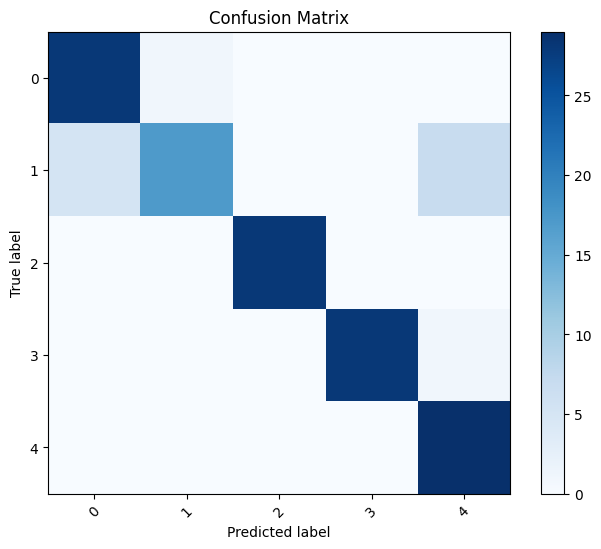

In [15]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(val_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(train_labels)))
plt.xticks(tick_marks, np.unique(train_labels), rotation=45)
plt.yticks(tick_marks, np.unique(train_labels))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
import numpy as np

# Definisi ulang train_hsv dari data latihan
train_hsv = load_data('Blocks2/train/images', 'Blocks2/train/labels.json')[2]

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)

unique_labels = np.unique(train_labels)

for label in unique_labels:
    h_values = []
    s_values = []
    v_values = []
    count = 0

    # Iterate over the range of the shorter list
    for i in range(min(len(train_labels), len(train_hsv))):
        if train_labels[i] == label:
            img_hsv = train_hsv[i]
            # Check the length of img_hsv before accessing elements
            if len(img_hsv) > 1:
                # Access the NumPy array within the tuple
                img_array = img_hsv[1]
                h_values.extend(img_array[:, :, 0].flatten())
                s_values.extend(img_array[:, :, 1].flatten())
                v_values.extend(img_array[:, :, 2].flatten())
                count += 1
            else:
                print(f"Warning: Invalid data format for sample at index {i}. Skipping.")

    if count > 0:
        h_values = np.array(h_values)
        s_values = np.array(s_values)
        v_values = np.array(v_values)

        print(f'Kelas: {label}')
        print(f'Nilai H - Min: {h_values.min()}, Max: {h_values.max()}, Mean: {h_values.mean()}')
        print(f'Nilai S - Min: {s_values.min()}, Max: {s_values.max()}, Mean: {s_values.mean()}')
        print(f'Nilai V - Min: {v_values.min()}, Max: {v_values.max()}, Mean: {v_values.mean()}')
        print(f'Jumlah Sampel: {count}')
        print('-' * 50)
    else:
        print(f'No matching items found for label: {label}')
        print('-' * 50)

Kelas: 0
Nilai H - Min: 0, Max: 179, Mean: 26.23976813422309
Nilai S - Min: 0, Max: 255, Mean: 48.26729956732856
Nilai V - Min: 0, Max: 255, Mean: 147.10238901774088
Jumlah Sampel: 90
--------------------------------------------------
Kelas: 1
Nilai H - Min: 0, Max: 179, Mean: 39.65679466433642
Nilai S - Min: 0, Max: 255, Mean: 43.57298036900962
Nilai V - Min: 0, Max: 255, Mean: 101.07182125928925
Jumlah Sampel: 82
--------------------------------------------------
Kelas: 2
Nilai H - Min: 0, Max: 179, Mean: 31.875971309474256
Nilai S - Min: 0, Max: 255, Mean: 55.65528682020844
Nilai V - Min: 0, Max: 255, Mean: 128.12878593069607
Jumlah Sampel: 122
--------------------------------------------------
Kelas: 3
Nilai H - Min: 0, Max: 179, Mean: 30.263417307535807
Nilai S - Min: 0, Max: 255, Mean: 61.97629712422689
Nilai V - Min: 0, Max: 255, Mean: 148.50102450052898
Jumlah Sampel: 120
--------------------------------------------------
Kelas: 4
Nilai H - Min: 0, Max: 179, Mean: 36.2823242836

In [25]:
# Evaluasi setiap gambar di set pengujian
image_evaluations = []

# Evaluasi setiap gambar di set pengujian
for idx, (image, true_label) in enumerate(zip(test_images, test_labels)):
    # Prediksi label menggunakan model Decision Tree
    pred_label = dt.predict([image])[0]

    # Hitung akurasi
    accuracy = 1 if pred_label == true_label else 0

    # Hitung precision, recall, dan f1-score
    precision = precision_score([true_label], [pred_label], average='macro', zero_division=0)
    recall = recall_score([true_label], [pred_label], average='macro', zero_division=0)
    f1 = f1_score([true_label], [pred_label], average='macro', zero_division=0)

    # Simpan hasil evaluasi dalam bentuk dictionary
    image_evaluations.append({
        'Image Index': idx,
        'True Label': true_label,
        'Predicted Label': pred_label,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Buat DataFrame dari hasil evaluasi
df_image_evaluations = pd.DataFrame(image_evaluations)

In [26]:
# Tampilkan hasil evaluasi setiap gambar di set pengujian
print("Evaluasi Setiap Gambar di Set Pengujian:")
print(df_image_evaluations)

Evaluasi Setiap Gambar di Set Pengujian:
    Image Index  True Label  Predicted Label  Accuracy  Precision  Recall  \
0             0           0                0         1        1.0     1.0   
1             1           0                0         1        1.0     1.0   
2             2           0                0         1        1.0     1.0   
3             3           0                0         1        1.0     1.0   
4             4           0                0         1        1.0     1.0   
..          ...         ...              ...       ...        ...     ...   
67           67           0                0         1        1.0     1.0   
68           68           0                0         1        1.0     1.0   
69           69           0                0         1        1.0     1.0   
70           70           0                0         1        1.0     1.0   
71           71           0                0         1        1.0     1.0   

    F1-Score  
0        1.0  
1   

Image Index: Indeks gambar dalam set pengujian.

True Label: Label sebenarnya dari gambar.

Predicted Label: Label yang diprediksi oleh model untuk gambar tersebut.

Accuracy: Akurasi prediksi untuk gambar tertentu. Nilai 1 menunjukkan prediksi yang benar, sedangkan nilai 0 menunjukkan prediksi yang salah.

Precision: Presisi dari prediksi untuk kelas tertentu. Presisi adalah rasio true positive dibagi dengan total prediksi positif yang dilakukan oleh model.

Recall: Recall atau ketepatan dari prediksi untuk kelas tertentu. Recall adalah rasio true positive dibagi dengan total data sebenarnya yang termasuk dalam kelas tersebut.

F1-Score: Skor F1 atau harmonic mean dari presisi dan recall. Skor F1 memberikan ukuran dari keseimbangan antara presisi dan recall.

In [28]:
import joblib

# Simpan model ke file
model_filename = 'decision_tree_model.pkl'
with open(model_filename, 'wb') as model_file:
    joblib.dump((dt, scaler, label_encoder), model_file)  # Now joblib is defined

print(f"Model disimpan sebagai {model_filename}")

Model disimpan sebagai decision_tree_model.pkl
